In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.cleaning import get_types_col
from src.metrics import all_metrics
import warnings
warnings.filterwarnings("ignore")


In [2]:
df_base = pd.read_csv('../data/training_inputs.csv', sep=';', decimal='.')
y = pd.read_csv('../data/training_outputs.csv', sep=';', decimal='.')
df_base = pd.merge(df_base, y, on='ID', how='inner')  

In [3]:
df = df_base.copy()

## 1: Traitement des données

--- 

Première étape pour un projet de data science: Nettoyer les données

In [4]:
df_base["Q66"].unique()

array(['true', 'false', nan, 'true '], dtype=object)

In [5]:
df, types = get_types_col(df)

Premier nettoiement des données et séparation des différents types de variables (qualitatives, quantitatives etc...)

#### Booléennes

In [6]:
df[types[0]].head(5)

,C5,C6,C7,Q7,Q16,Q52,Q53,Q54,Q55,Q56,...,Q70,Q71,Q72,Q73,Q74,Q75,C14,C4,C9,C8
0,False,False,False,False,False,NaN,False,NaN,NaN,NaN,...,True,False,False,NaN,NaN,NaN,True,True,True,True
1,False,False,False,NaN,False,False,True,True,False,True,...,True,False,False,True,False,False,True,False,True,False
2,False,False,False,NaN,False,NaN,False,False,False,True,...,True,False,False,NaN,NaN,NaN,False,False,True,False
3,False,False,False,NaN,True,NaN,False,False,False,False,...,True,False,False,NaN,NaN,NaN,True,True,True,False
4,False,False,False,False,False,NaN,False,NaN,NaN,NaN,...,True,False,False,NaN,NaN,NaN,False,True,True,True


#### Qualitatives

In [7]:
df[types[1]].head(5)

,C12,C2,C13,Q39,Q1,Q11,Q34,Q10,Q2,Q12,Q3,Q36,Q29,Q28,Q32,C3
0,OB,RA,RC,NaN,HA,D7,ED,PC,ZA,EA,UC,AC,IA,ZA,LC,C
1,OB,RA,RC,NaN,HC,DS,ED,PC,ZA,E8,UC,AC,ID,ZF,LC,C
2,OC,RC,R7,NaN,HC,D3,EF,PD,ZA,EA,UA,AD,IA,ZF,LA,B
3,OA,RA,RC,NaN,HC,DB,ED,PA,ZA,EA,UC,AC,IA,ZA,LD,C
4,OB,RA,RC,NaN,HA,DF,ED,PC,ZA,EA,UA,AC,IA,ZA,LD,B


#### Quantitatives

In [8]:
df[types[2]].head(5)

,C10,C11,C15,C16,C17,C18,C19,S1,S2,S8,...,Q42,Q43,Q44,Q45,Q46,Q47,Q48,Q49,Q50,Q51
0,8,2286,2,214,212,16,7,1.0,0,6,...,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0
1,166,2220,3,511,414,15,19,3.0,2,11,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
2,17,2265,4,407,405,17,8,NaN,0,1,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,16,2250,3,712,410,16,12,4.0,1,10,...,0.0,0.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,3.0
4,23,2305,1,206,204,17,4,NaN,1,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


#### Temporelles

In [9]:
df[types[-1]].head(5)

,S3,S4,S5,S6,S7
0,2013-11-15,2014-02-22,2013-09-08,2013-09-07,2013-09-07
1,2013-11-15,2014-08-07,2013-04-18,2013-09-14,2014-03-21
2,2013-11-15,2013-11-05,2013-11-05,NaT,NaT
3,2013-11-15,2014-05-30,2013-07-03,2014-01-30,2014-05-18
4,2013-11-15,2013-09-22,2013-09-22,NaT,NaT


### Présentation du problème

On cherche à prédire la variable "TARGET", qui contient 20% de 1 (pour 80% de 0)

In [10]:
df["TARGET"].mean()

0.19359515485975518

Il est évident que dans cette configuration, certaines métriques comme l'accuracy ne sont pas très pertinentes

In [11]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report

In [12]:
print(classification_report(df["TARGET"].to_numpy(), [0]*df.shape[0]))

              precision    recall  f1-score   support

       False       0.81      1.00      0.89     68971
        True       0.00      0.00      0.00     16558

    accuracy                           0.81     85529
   macro avg       0.40      0.50      0.45     85529
weighted avg       0.65      0.81      0.72     85529



D'autres métriques telles que le F1 score ou le ROC AUC sont plus pertinentes

In [13]:
roc_auc_score(df["TARGET"].to_numpy(), [0]*df.shape[0])

0.5

In [14]:
float(roc_auc_score(df["TARGET"].to_numpy(), np.random.randint(0, 2, size=df.shape[0])))

0.5019872426815579

In [15]:
f1_score(df["TARGET"].to_numpy(), np.random.randint(0, 2, size=df.shape[0]))

0.2788954901431272

On peut montrer analytiquement facilement que pour un prédicteur aléatoire (d'une loi uniforme), on peut choisir le seuil tel que l'espérance du F1 score est de $2*\frac{\lambda}{1+\lambda}$ où $\lambda$ est la part de label 1 dans le dataset (dans notre cas $\approx 0.2$ donc le F1 score d'un prédicteur aléatoire peut atteindre $\approx 1/3$)

#### Gérer les NAN

Pour les variables catégorielles, on se permet de remplir simplement par "Unknown" les variables avec des NaN

In [16]:
df.fillna({col: "Unknown" for col in types[1]}, inplace=True)
df[types[1]].head(5)

,C12,C2,C13,Q39,Q1,Q11,Q34,Q10,Q2,Q12,Q3,Q36,Q29,Q28,Q32,C3
0,OB,RA,RC,Unknown,HA,D7,ED,PC,ZA,EA,UC,AC,IA,ZA,LC,C
1,OB,RA,RC,Unknown,HC,DS,ED,PC,ZA,E8,UC,AC,ID,ZF,LC,C
2,OC,RC,R7,Unknown,HC,D3,EF,PD,ZA,EA,UA,AD,IA,ZF,LA,B
3,OA,RA,RC,Unknown,HC,DB,ED,PA,ZA,EA,UC,AC,IA,ZA,LD,C
4,OB,RA,RC,Unknown,HA,DF,ED,PC,ZA,EA,UA,AC,IA,ZA,LD,B


In [17]:
list_types = ["Bool", "Qualitative", "Quantitative", "Temporelle"]
to_drop_nan = set()

for cat, list_col in zip(list_types, types):
    if cat == "Qualitative":
        continue

    missing_rate = df[list_col].isna().mean()
    print(cat, "\n", f"Nombre de variables : {len(list_col)}\n", "% de colonnes qui contiennent:\n")
    print(f" Au moins un Nan {len(missing_rate[missing_rate > 0.].index)/len(list_col)}")
    print(f" Au moins 10% de NaN {len(missing_rate[missing_rate > 0.1].index)/len(list_col)}")
    print(f" Au moins 50% de NaN: {len(missing_rate[missing_rate > 0.5].index)/len(list_col)}")
    print(f" Au moins 80% de NaN {len(missing_rate[missing_rate > 0.8].index)/len(list_col)}")

    to_drop_nan.update(missing_rate[missing_rate > 0.5].index)
    
    print('\n', "-"*50, "\n")

print("Colonnes à supprimer:", to_drop_nan)


Bool 
 Nombre de variables : 33
 % de colonnes qui contiennent:

 Au moins un Nan 0.7878787878787878
 Au moins 10% de NaN 0.2727272727272727
 Au moins 50% de NaN: 0.06060606060606061
 Au moins 80% de NaN 0.0

 -------------------------------------------------- 

Quantitative 
 Nombre de variables : 51
 % de colonnes qui contiennent:

 Au moins un Nan 0.7254901960784313
 Au moins 10% de NaN 0.19607843137254902
 Au moins 50% de NaN: 0.13725490196078433
 Au moins 80% de NaN 0.09803921568627451

 -------------------------------------------------- 

Temporelle 
 Nombre de variables : 5
 % de colonnes qui contiennent:

 Au moins un Nan 0.4
 Au moins 10% de NaN 0.4
 Au moins 50% de NaN: 0.0
 Au moins 80% de NaN 0.0

 -------------------------------------------------- 

Colonnes à supprimer: {'Q6', 'Q15', 'Q17', 'Q18', 'Q52', 'Q38', 'Q37', 'Q7', 'Q40'}


La plupart des variables contiennent au moins un NaN mais on voit que la plupart contiennent moins de 10% de NaN

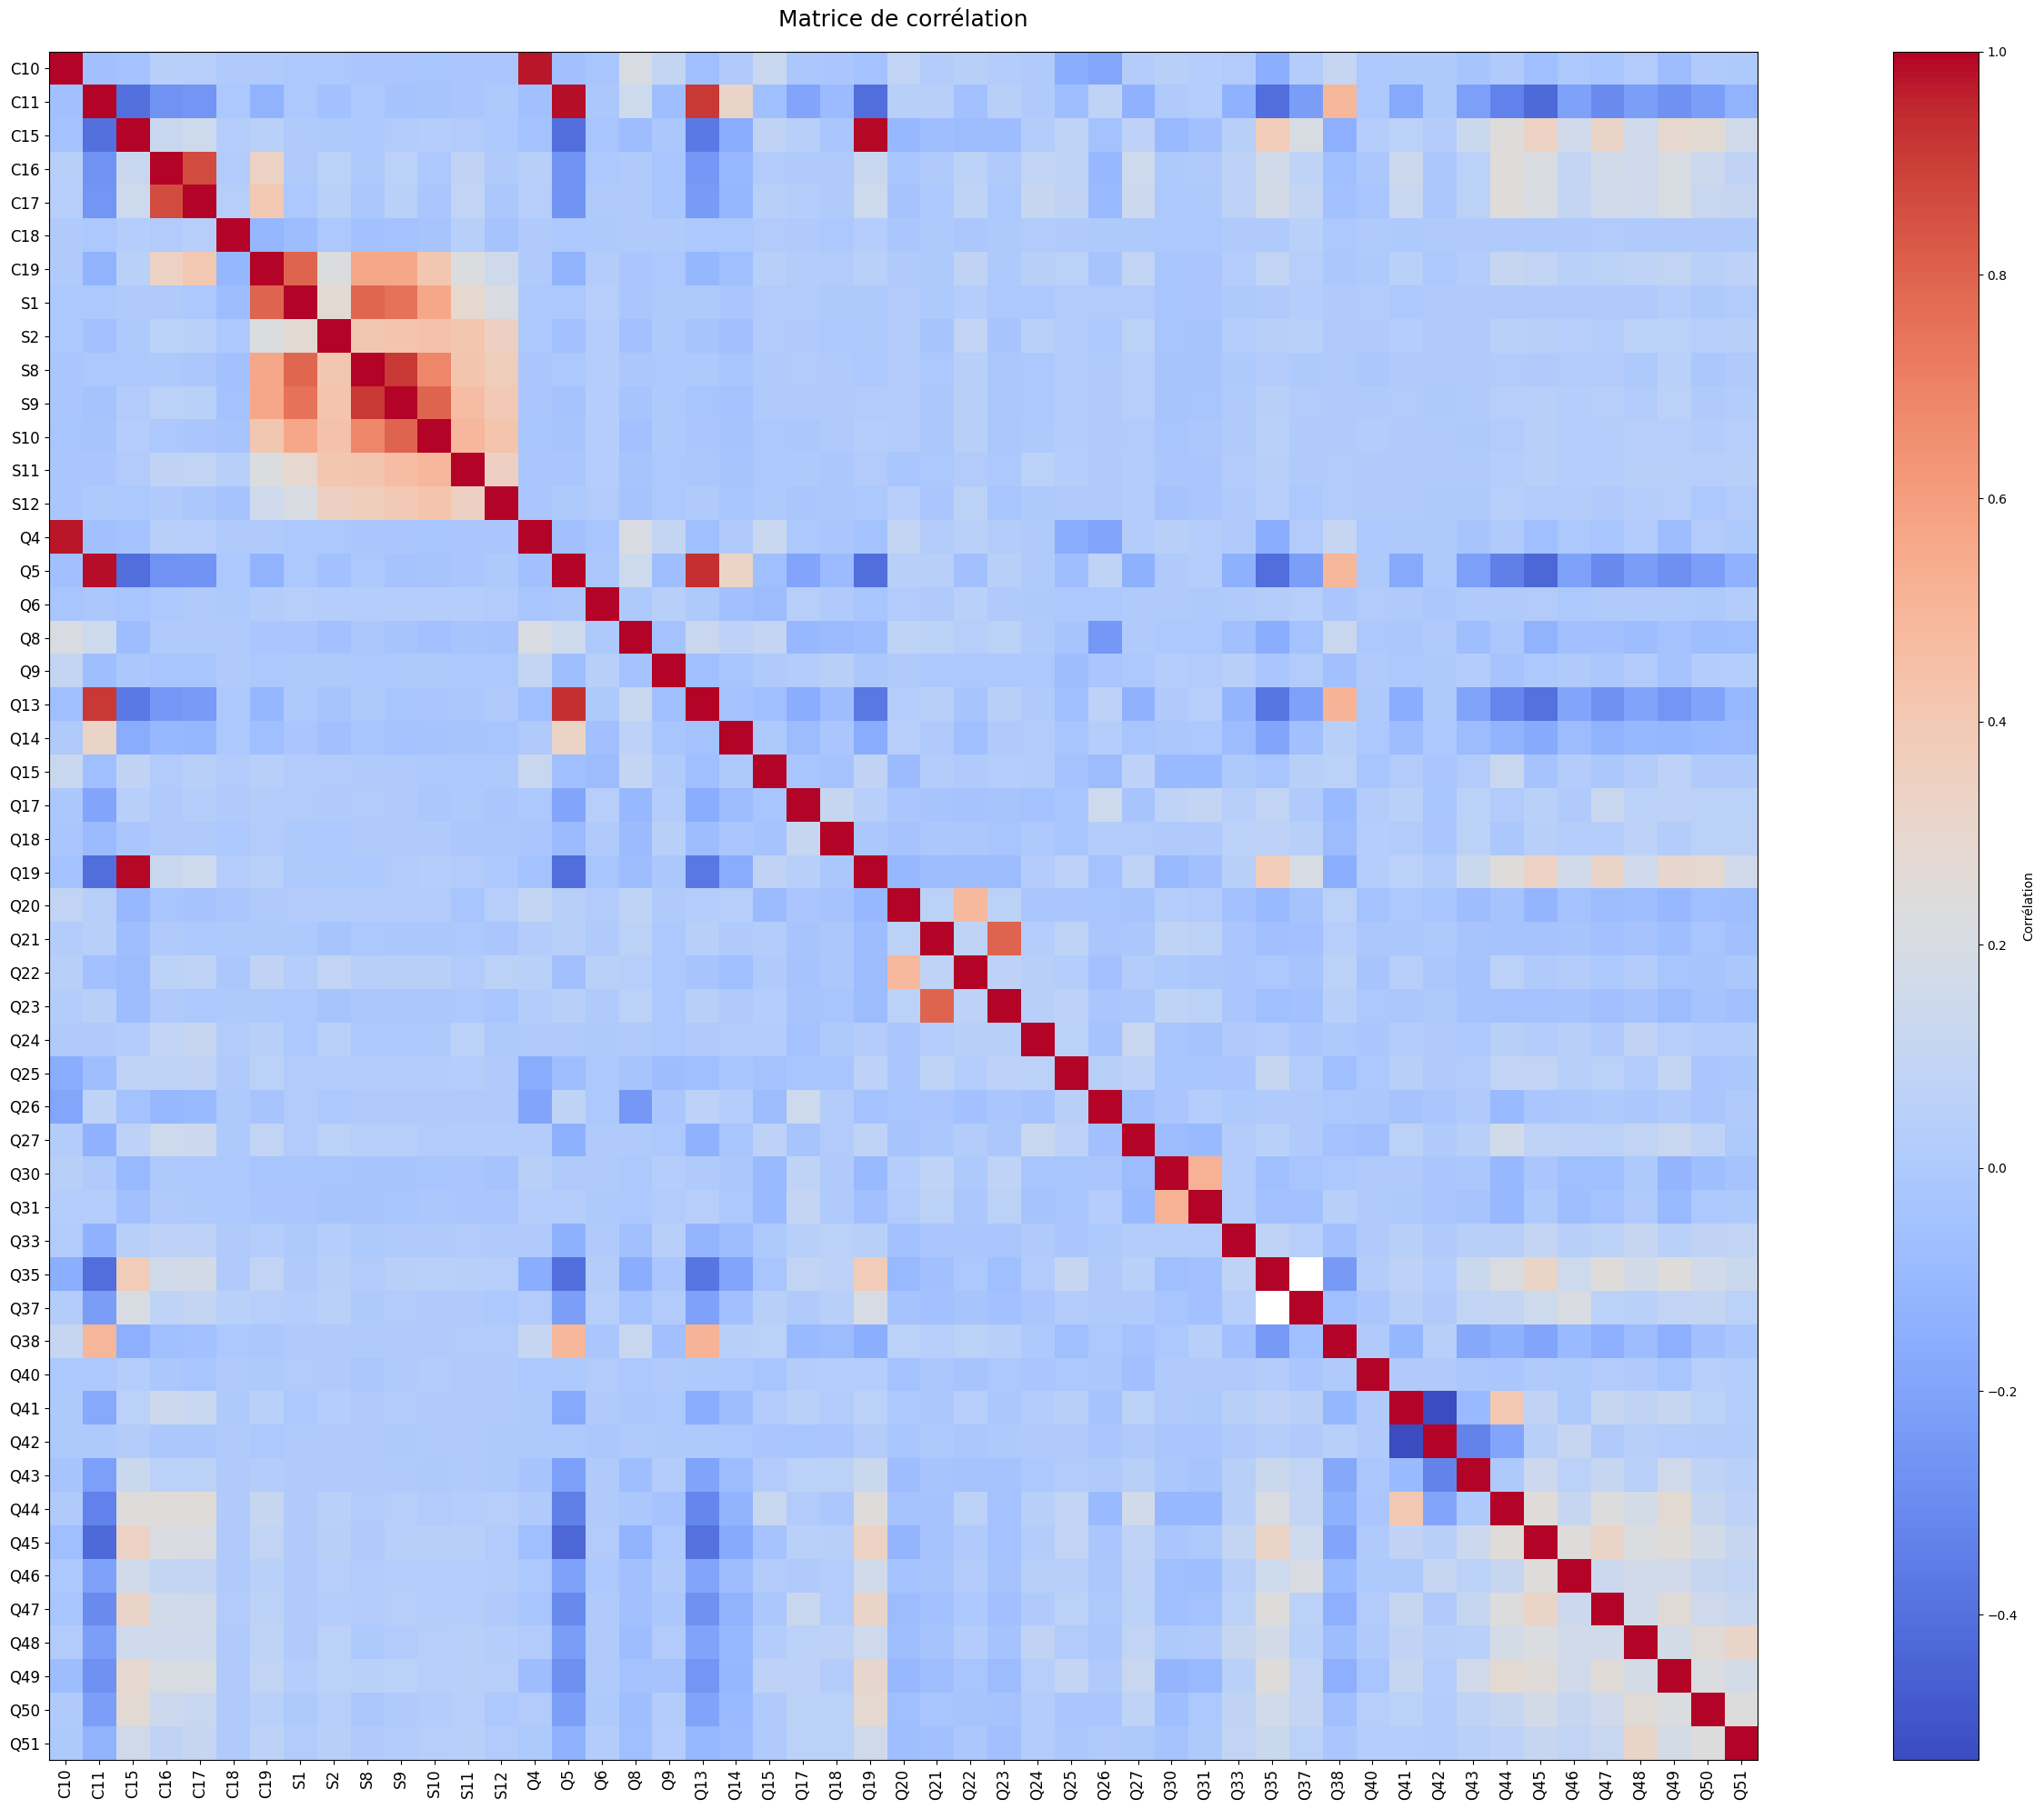

In [18]:
float_vars = df[types[2]]

cov_matrix = float_vars.corr()

plt.figure(figsize=(30, 20))
plt.imshow(cov_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label="Corrélation")
plt.title('Matrice de corrélation', pad=20, fontsize=18)

plt.xticks(range(len(cov_matrix.columns)), cov_matrix.columns, rotation=90, fontsize=12)
plt.yticks(range(len(cov_matrix.columns)), cov_matrix.columns, fontsize=12)

plt.tight_layout()
plt.show()

In [19]:
to_drop_corr = set()

for i in range(len(cov_matrix.columns)):
    for j in range(i + 1, len(cov_matrix.columns)):
        if abs(cov_matrix.iloc[i, j]) > 0.8:
            colname_1 = cov_matrix.columns[j]
            colname_2 = cov_matrix.columns[i]
            argmin = np.argmin(np.abs(df[[colname_1, colname_2, "TARGET"]].corr().to_numpy()[-1,:2]))
            colname = colname_1 if argmin==0 else colname_2
            to_drop_corr.add(colname)

print("Colonnes à supprimer pour corrélation > 80% :")
print(to_drop_corr)


Colonnes à supprimer pour corrélation > 80% :
{'Q13', 'C11', 'C10', 'S8', 'C17', 'C15'}


On supprime aussi les variables qualitatives qui ont trop de valeurs différentes (risque d'exploser le nombre de feature car on les converti en OHE). Si les variables avaient un sens plus concret, je déconseillerai cette méthode et je chercherai plutot à créer des variables a partir de celles ci. Mais ici si on a deux variables qui ont 30 valeurs différentes on doit crée 58 dummie ce qui est très élevé

In [20]:
to_drop_uni = set()

for col in types[1]:
    n_unique = df[col].nunique()
    if n_unique>10:
        to_drop_uni.add(col)

print("Colonnes à supprimer (trop de valeurs différentes):")
print(to_drop_uni)      

Colonnes à supprimer (trop de valeurs différentes):
{'Q28', 'Q34', 'Q11', 'Q12'}


Pour les variables temporelles, on peut créer des features plus simples tels que la saison ou les mois

In [ ]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Hiver'
    elif month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Été'
    else:
        return 'Automne'

temp = []
for colname in types[-1]:
    df[f"{colname}_season"] = df[colname].apply(get_season).fillna("Unknown")
    temp.append(f"{colname}_season")
for item in temp:
    types[-1].append(item) 

In [29]:
for colname in types[-1][:len(types)//2 + 1]:
    df[colname] = df[colname].dt.month.fillna(-1)

In [30]:
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [31]:
to_drop = to_drop_corr.union(to_drop_nan).union(to_drop_uni)

<Figure size 1000x600 with 0 Axes>

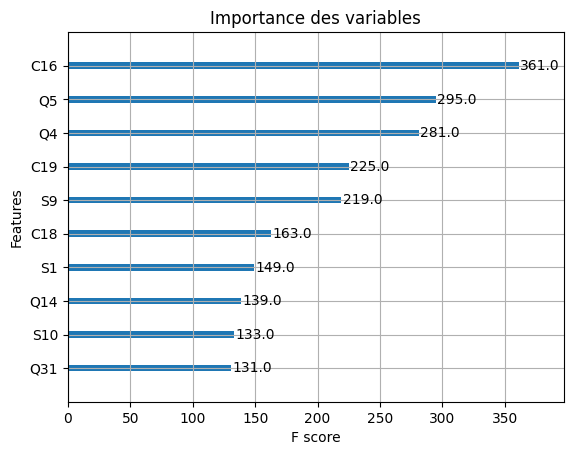

In [32]:
X = df.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID']+types[-1]).fillna(0)
X = X.drop(to_drop, axis=1)
y = df['TARGET']
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

model = XGBClassifier(scale_pos_weight=scale_pos_weight, 
                      objective='binary:logistic', 
                      eval_metric='auc', 
                      enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='weight')
plt.title("Importance des variables")
plt.show()

importances = model.get_booster().get_score(importance_type='weight')
top_features_xgboost = sorted(importances, key=importances.get, reverse=True)[:10]


              precision    recall  f1-score   support

       False       0.89      0.69      0.78     13794
        True       0.33      0.63      0.43      3312

    accuracy                           0.68     17106
   macro avg       0.61      0.66      0.60     17106
weighted avg       0.78      0.68      0.71     17106

AUC: 0.7201
AUPR: 0.3693
FPR95% : 0.7561


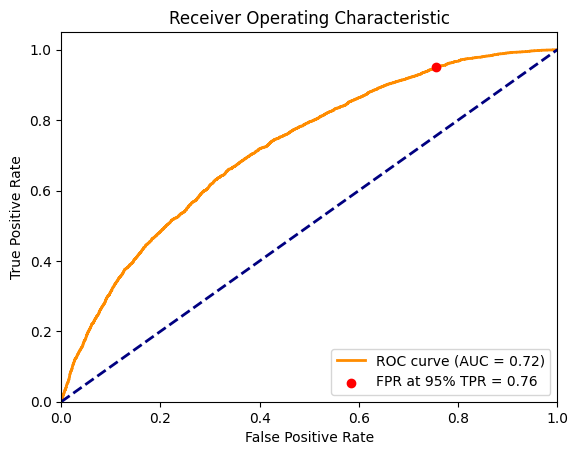

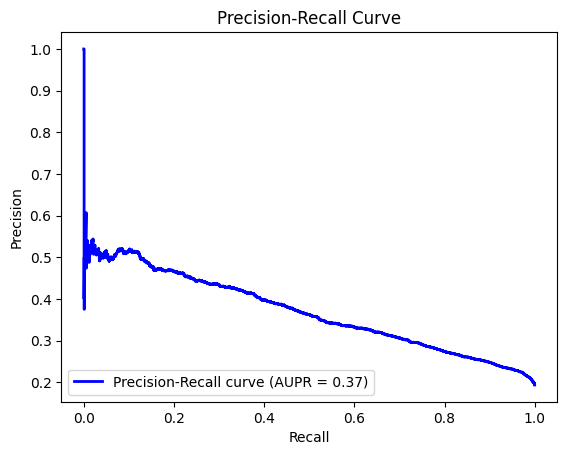

In [33]:
_ = all_metrics(y_test, y_pred_prob, verbose=True)

              precision    recall  f1-score   support

       False       0.88      0.72      0.79     13794
        True       0.34      0.60      0.43      3312

    accuracy                           0.69     17106
   macro avg       0.61      0.66      0.61     17106
weighted avg       0.78      0.69      0.72     17106

AUC: 0.7187
AUPR: 0.3672
FPR95% : 0.7584


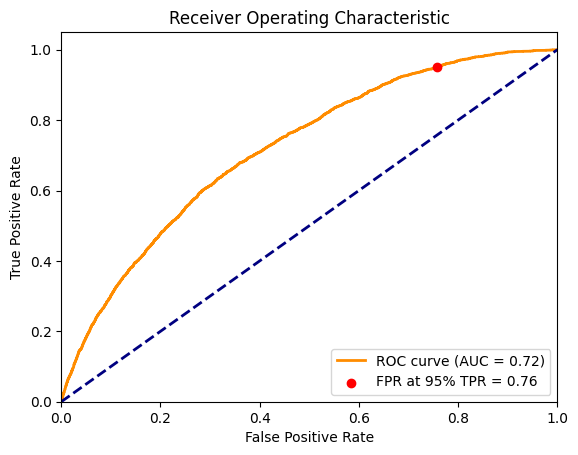

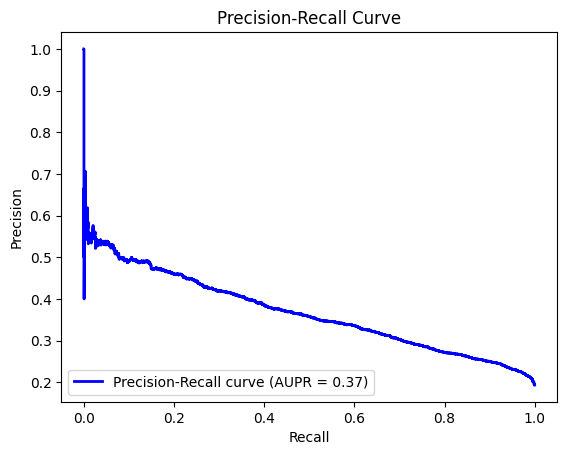

In [34]:
X = df.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID']+types[-1])
X = X.drop(to_drop, axis=1)
y = df['TARGET']
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier(
                      objective='binary:logistic', 
                      eval_metric='auc', 
                      enable_categorical=True)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

_ = all_metrics(y_test, y_pred_prob, verbose=True)

Ici on voit que rajouter le paramètre de "poids" dans XGBoost ne change pas vraiment les résultats (étant donné que je sélectionne après le threshold qui maximise le F1 score)

Nos résultats ne sont pas terribles, (en plus si on ne retire aucune variables, on obtient a peu près les même résultats)

0:	learn: 0.6873889	total: 139ms	remaining: 2m 18s
100:	learn: 0.6053798	total: 14.9s	remaining: 2m 12s
200:	learn: 0.5934220	total: 32.1s	remaining: 2m 7s
300:	learn: 0.5810300	total: 46.9s	remaining: 1m 48s
400:	learn: 0.5704981	total: 1m	remaining: 1m 30s
500:	learn: 0.5614268	total: 1m 14s	remaining: 1m 14s
600:	learn: 0.5533607	total: 1m 32s	remaining: 1m 1s
700:	learn: 0.5460472	total: 1m 56s	remaining: 49.6s
800:	learn: 0.5391498	total: 2m 15s	remaining: 33.7s
900:	learn: 0.5328679	total: 2m 39s	remaining: 17.6s
999:	learn: 0.5269434	total: 3m 5s	remaining: 0us
              precision    recall  f1-score   support

       False       0.89      0.68      0.77     13794
        True       0.33      0.66      0.44      3312

    accuracy                           0.67     17106
   macro avg       0.61      0.67      0.61     17106
weighted avg       0.78      0.67      0.71     17106

AUC: 0.7340
AUPR: 0.3904
FPR95% : 0.7295


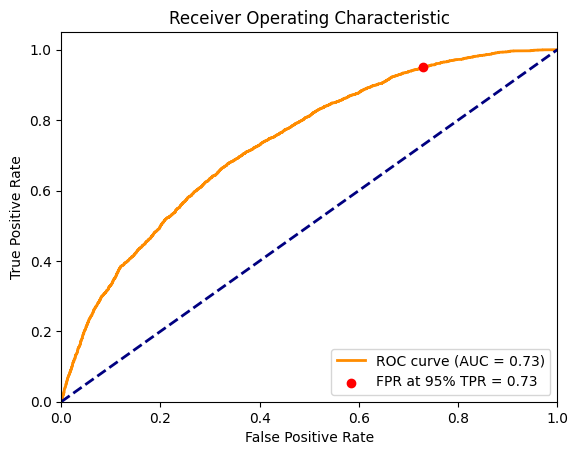

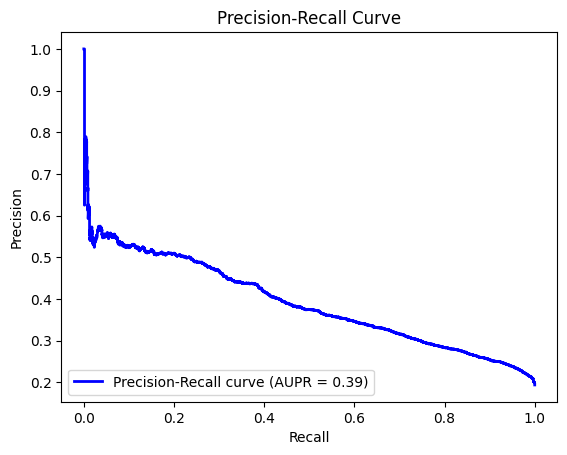

In [44]:
from catboost import CatBoostClassifier

dft = df.copy()
for col in types[0]:
    dft[col] = dft[col].fillna(0).astype(int)
for col in types[2]:
    dft[col] = dft[col].fillna(df[col].median())

for col in types[3][:len(types[3])//2]:
    dft[col] = dft[col].fillna(df[col].median()).astype(str)

for col in types[3][len(types[3])//2:]:
    dft[col] = dft[col].fillna("Unknown").astype(str)


X = dft.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID']+types[-1])
X = X.drop(to_drop, axis=1)
y = df['TARGET']
#X_encoded = pd.get_dummies(X, drop_first=True)
cat_features = [col for col in X.columns if col in (types[1] + types[3])]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    cat_features=cat_features,
    l2_leaf_reg=5,
    auto_class_weights='Balanced'
)

model.fit(X_train, y_train, cat_features=cat_features, verbose=100)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

_ = all_metrics(y_test, y_pred_prob, verbose=True)


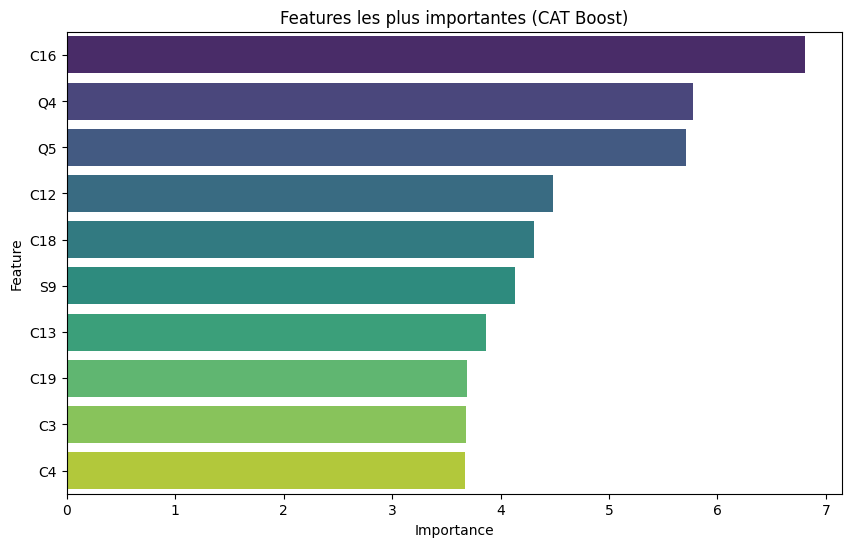

In [45]:
importances = model.get_feature_importance()
features = X.columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_features_cat = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features_cat, palette='viridis')

plt.title('Features les plus importantes (CAT Boost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

On obtient des résultats légèremment meilleurs avec catboost et on peut penser qu'en optimisant un modèle on pourra atteindre environ 50% de F1 score (avec nos variables). Mais la meilleure approche (selon moi) reste a bien sélectionner les variables et continuer l'exploration.

On remarque dans un premier temps que les variables les plus importantes des deux modèles sont proches

In [46]:
top_features_cat.Feature.to_list()

['C16', 'Q4', 'Q5', 'C12', 'C18', 'S9', 'C13', 'C19', 'C3', 'C4']

In [47]:
top_features_xgboost

['C16', 'Q5', 'Q4', 'C19', 'S9', 'C18', 'S1', 'Q14', 'S10', 'Q31']

Qui ne sont d'ailleurs pas les variables avec la plus fortes corrélation (avec l'outcome TARGET). Une chose intéressante est que on n'a pas une "classe" (parmis S, C, ou Q) qui est significativement plus présente que les autres. Cependant, on voit clairement que TOUTE les variables sont quantitatives (pour XGBOOST)

In [48]:
for feature in top_features_xgboost:
    found = False
    for idx, sublist in enumerate(types):
        if feature in sublist:
            print(f"{feature} est présent dans la liste {idx + 1}")
            found = True

C16 est présent dans la liste 3
Q5 est présent dans la liste 3
Q4 est présent dans la liste 3
C19 est présent dans la liste 3
S9 est présent dans la liste 3
C18 est présent dans la liste 3
S1 est présent dans la liste 3
Q14 est présent dans la liste 3
S10 est présent dans la liste 3
Q31 est présent dans la liste 3


In [49]:
for feature in top_features_cat.Feature.to_list():
    found = False
    for idx, sublist in enumerate(types):
        if feature in sublist:
            print(f"{feature} est présent dans la liste {idx + 1}")
            found = True

C16 est présent dans la liste 3
Q4 est présent dans la liste 3
Q5 est présent dans la liste 3
C12 est présent dans la liste 2
C18 est présent dans la liste 3
S9 est présent dans la liste 3
C13 est présent dans la liste 2
C19 est présent dans la liste 3
C3 est présent dans la liste 2
C4 est présent dans la liste 1


#### Tentative de réduire la dimension des variables

Avec un algorithme tel que PCA (ou TSNE) on peut réduire la dimension de vecteurs en conservant le plus d'informations possibles. On peut utiliser cette approche pour synthetiser les informations du client (description du client (C), detail sur son utilise d'aides (S) et réponses aux questions sur leurs equipement et utilisation (Q))

In [50]:
from src.pca_utils import get_pca_features, plot_pca_2d

X = dft.drop(columns=['TARGET', 'COD_INSEE', 'COD_IRIS', 'ID']).fillna(0)
X = X.drop(to_drop, axis=1)
y = dft['TARGET']
X_encoded = pd.get_dummies(X, drop_first=True).fillna(0)

q_pca, s_pca, c_pca = get_pca_features(X_encoded)

X_encoded = pd.concat([X_encoded, q_pca, s_pca, c_pca], axis=1)

X_encoded.head()

,C4,C5,C6,C7,C8,C9,C14,C16,C18,C19,...,C_pca_1,C_pca_2,C_pca_3,C_pca_4,C_pca_5,C_pca_6,C_pca_7,C_pca_8,C_pca_9,C_pca_10
0,1,0,0,0,1,1,1,214,16,7,...,1.284050,-1.191091,0.448843,0.716788,1.316639,-0.249754,-0.163768,0.311802,0.026500,0.215576
1,0,0,0,0,0,1,1,511,15,19,...,0.960685,0.681703,-0.136717,-0.444988,1.345337,0.441405,-0.037659,0.441298,-0.060950,0.044742
2,0,0,0,0,0,1,0,407,17,8,...,-4.423569,-2.438633,-8.825978,-0.958260,0.864705,-0.163577,-0.227357,-2.394054,-2.985280,-1.029699
3,1,0,0,0,0,1,1,712,16,12,...,0.804451,2.021941,-0.309489,1.440613,0.887552,0.194968,-0.151882,0.428496,-0.533843,-0.345781
4,1,0,0,0,1,1,0,206,17,4,...,-0.272519,-2.935652,1.021965,0.401360,-0.308130,-0.611378,-0.177129,-0.397011,-0.001562,-0.061911


En projetant en les 2 premiers axes sur un graphiques, on voit cependant que cet encodage ne permet pas dans un premier lieu de bien différencier nos données

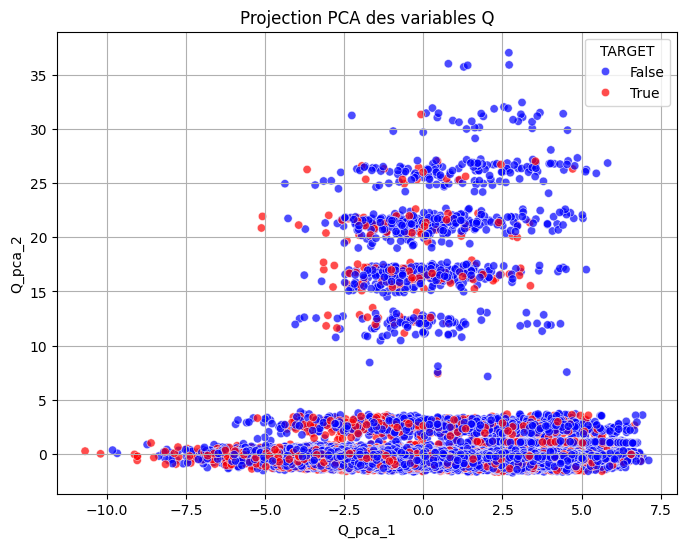

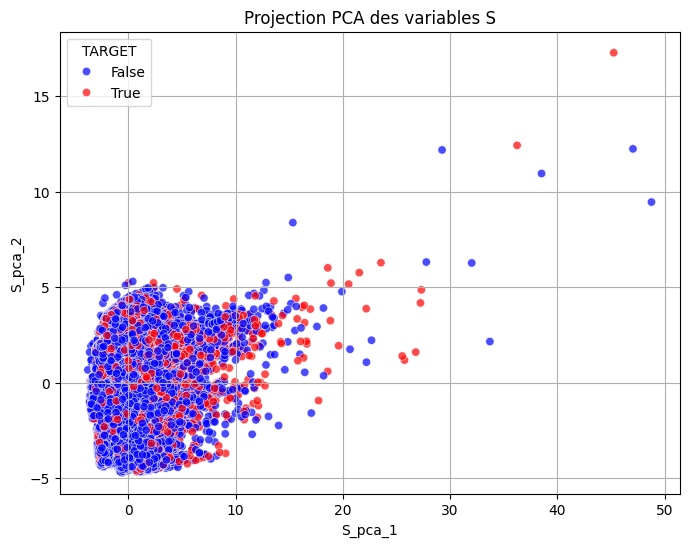

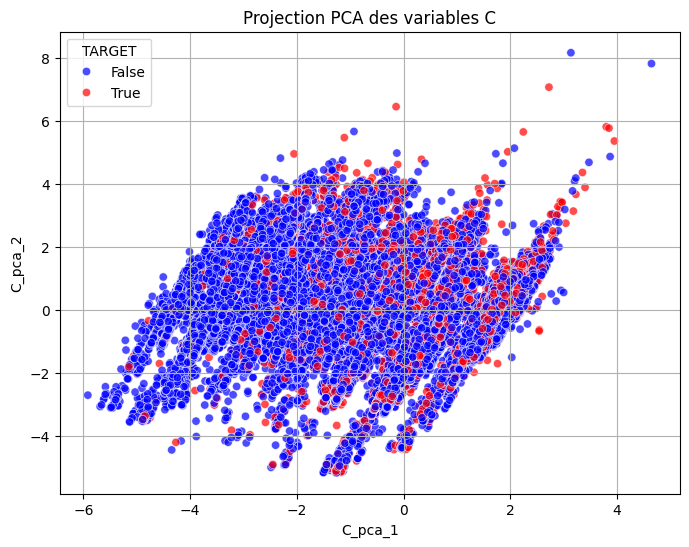

In [51]:

plot_pca_2d(q_pca.iloc[:, :2], y, 'Projection PCA des variables Q')
plot_pca_2d(s_pca.iloc[:, :2], y, 'Projection PCA des variables S')
plot_pca_2d(c_pca.iloc[:, :2], y, 'Projection PCA des variables C')


Pas très pertinent pour notre tâche de classification...